# Imports

In [327]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns
import time

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.6.1 installed at C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\camb


# Data generating process

## Definitions

In [328]:
def generate_logPK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 1, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    # noise = rng.normal(0, noise_level * P_k)
    # P_k_noisy = P_k + noise

    # Step 2: Apply log10 to each output
    log_k = np.log10(k_vals)
    #log_P_k_noisy = np.log10(P_k_noisy)
    
    
    
    
    log_P_k_clean = np.log10(P_k)

    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise
    
    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {     
        'log_k': log_k,
        'log_P_k_noisy': log_P_k_noisy,
        'log_P_k_clean': log_P_k_clean  
    }

## Generating noisy observations

$\theta^*$, True parameter from Planck 2018

In [329]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [330]:
# Generate the noisy power spectrum using theta_star
Log_Pk_obs = generate_logPK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

## Visualization

P(k) vs k_vals

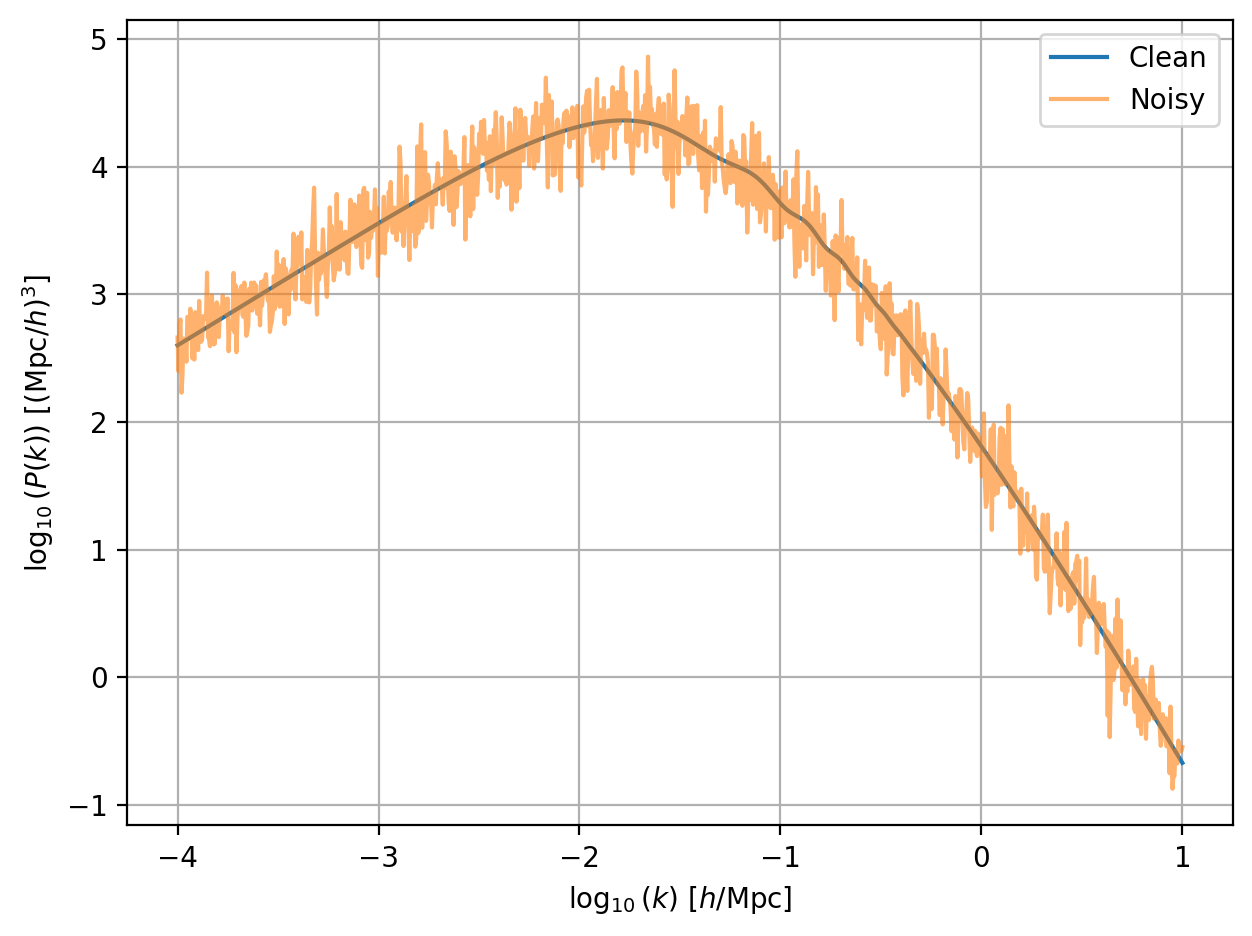

In [331]:
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_clean'], label='Clean')
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel(r'$\log_{10}(k)\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\log_{10}(P(k))\ [(\mathrm{Mpc}/h)^3]$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

$f(P\_k))$, probability density of power spectrum

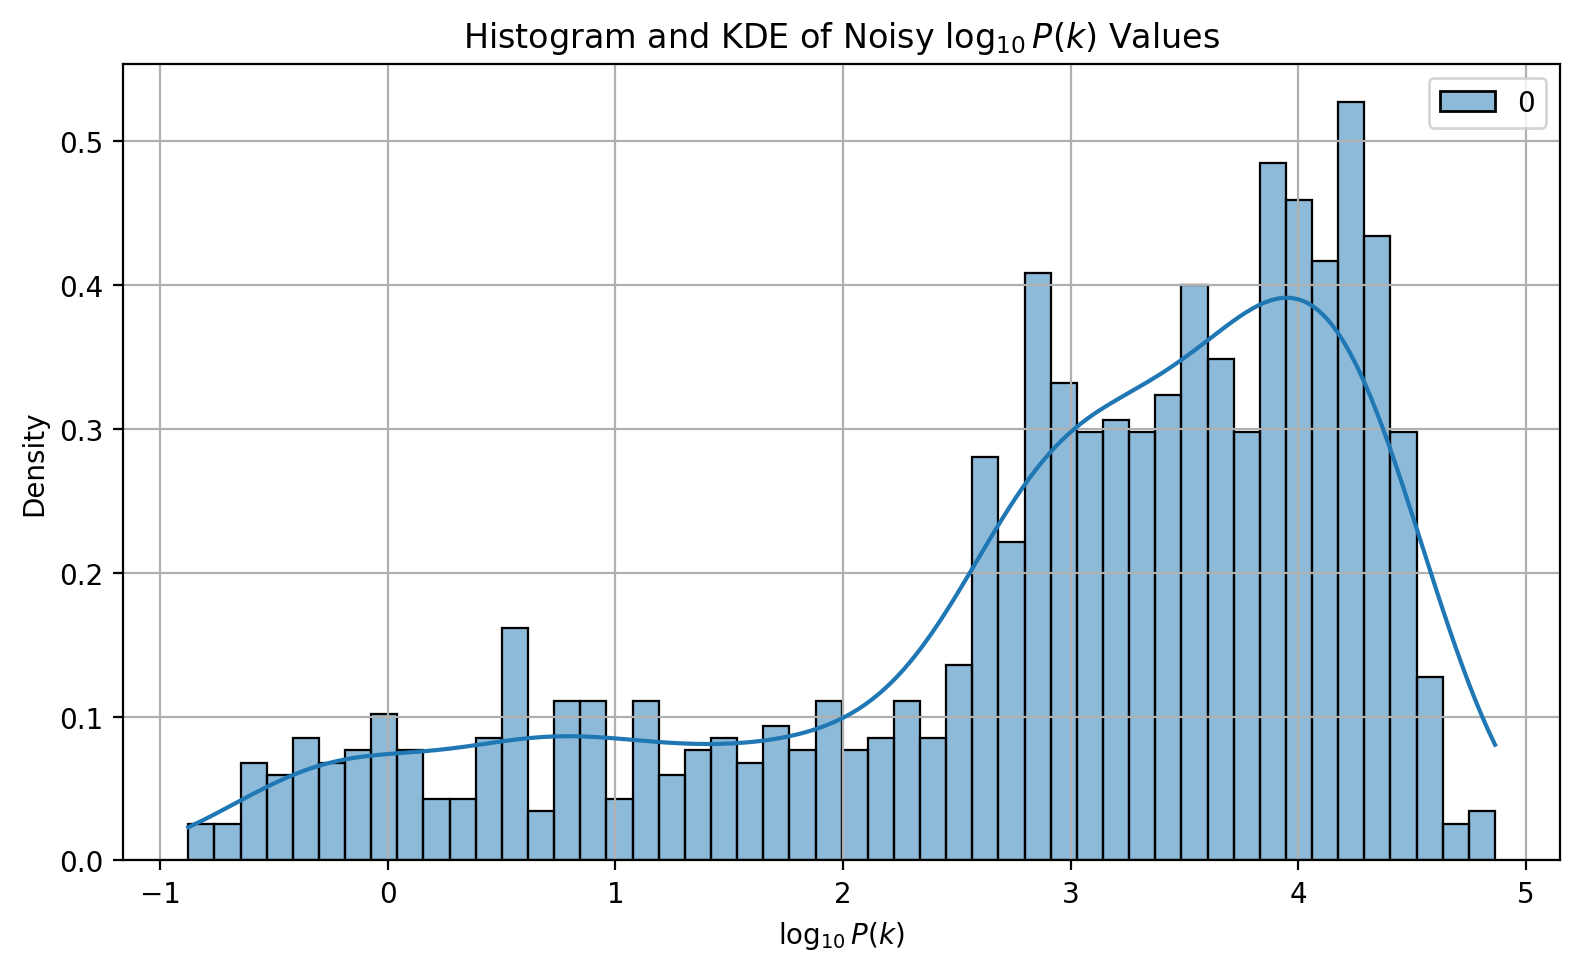

In [332]:

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_obs['log_P_k_noisy'], bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


## Definitions part 2

Sample from prior: $(\theta^{(s)}) \sim P(\theta)$

In [333]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(30, 100)
    Omega_m = rng.uniform(0.1, 0.6)
    n_s = rng.uniform(0.8, 1.5)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


# Prior Plots

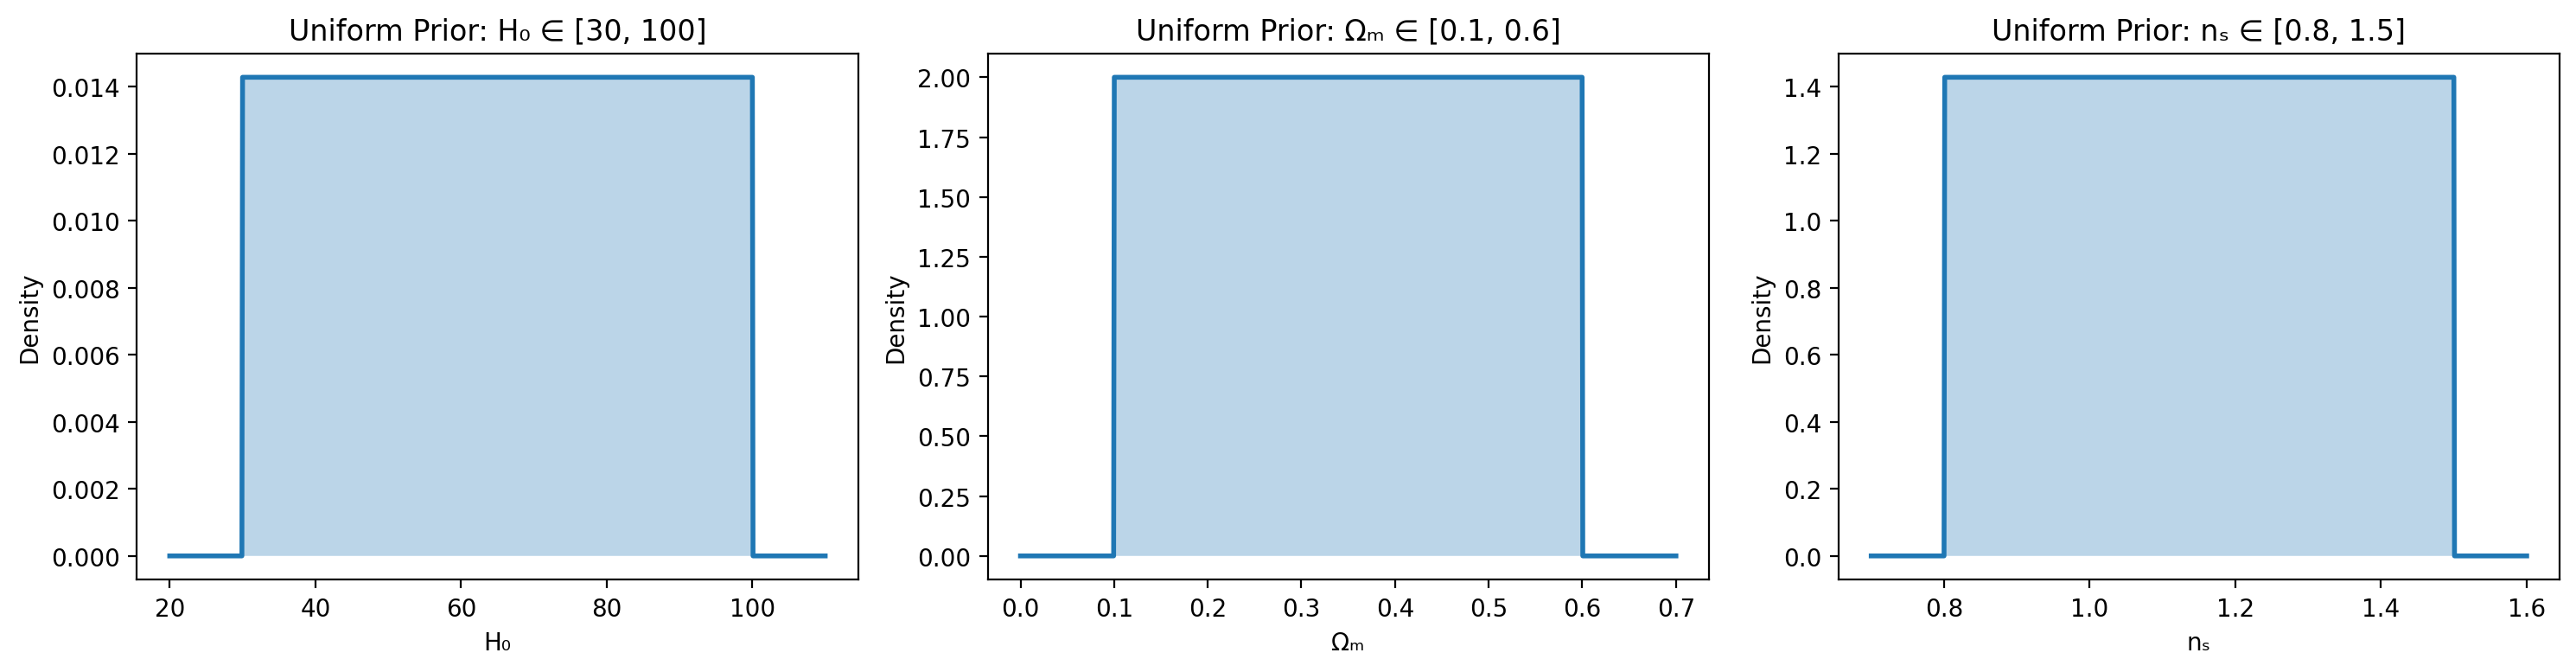

In [451]:

# Parameter ranges
H0_range = (30, 100)
Om_range = (0.1, 0.6)
ns_range = (0.8, 1.5)

# Define x values
x_H0 = np.linspace(20, 110, 1000)
x_Om = np.linspace(0, 0.7, 1000)
x_ns = np.linspace(0.7, 1.6, 1000)

# Uniform densities
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Compute densities
y_H0 = uniform_density(x_H0, *H0_range)
y_Om = uniform_density(x_Om, *Om_range)
y_ns = uniform_density(x_ns, *ns_range)

# Plotting
plt.figure(figsize=(15, 4))

# H0
plt.subplot(1, 3, 1)
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')

# Ωm
plt.subplot(1, 3, 2)
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')

# ns
plt.subplot(1, 3, 3)
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


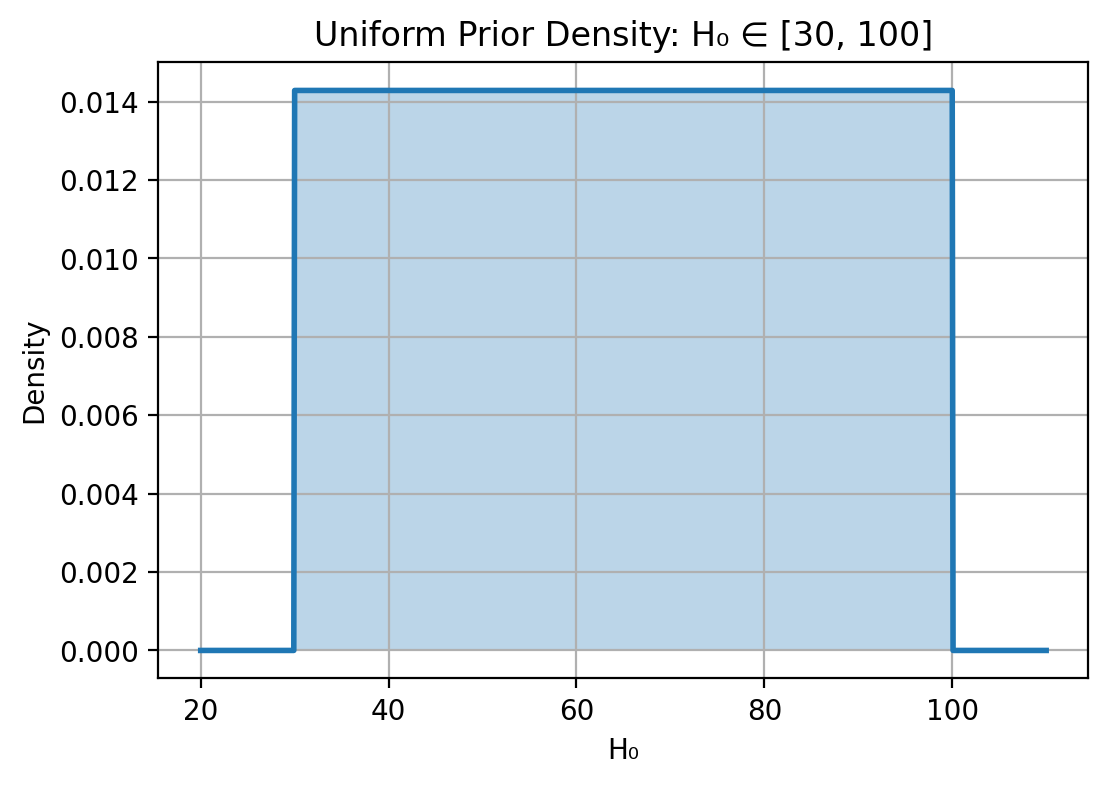

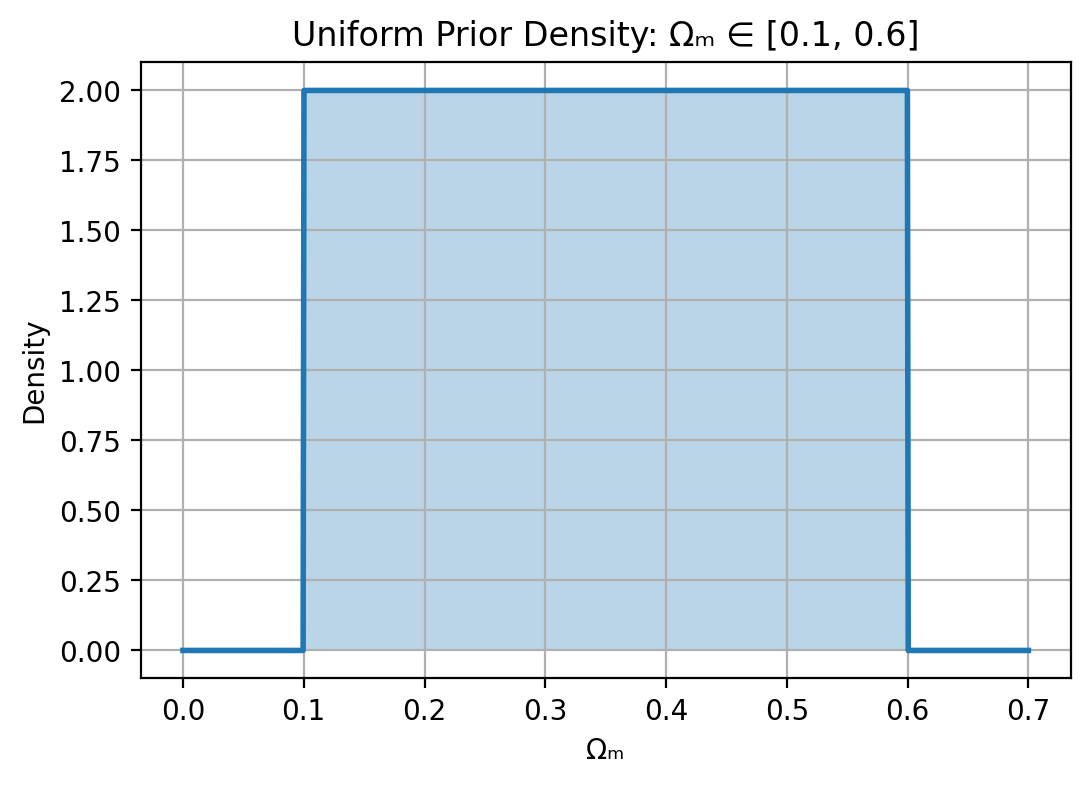

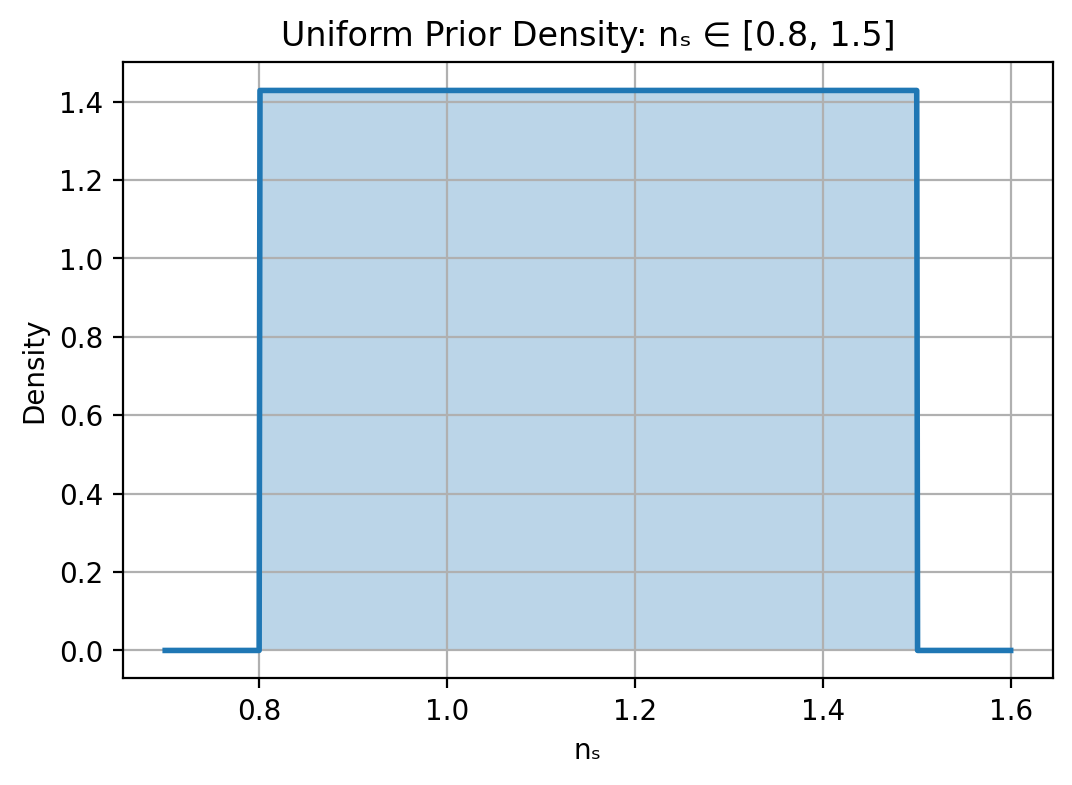

In [452]:

# Uniform density function
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Plot 1: Hubble constant H0
x_H0 = np.linspace(20, 110, 1000)
y_H0 = uniform_density(x_H0, 30, 100)

plt.figure(figsize=(6, 4))
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior Density: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 2: Matter density Ωm
x_Om = np.linspace(0, 0.7, 1000)
y_Om = uniform_density(x_Om, 0.1, 0.6)

plt.figure(figsize=(6, 4))
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior Density: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: Spectral index ns
x_ns = np.linspace(0.7, 1.6, 1000)
y_ns = uniform_density(x_ns, 0.8, 1.5)

plt.figure(figsize=(6, 4))
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior Density: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Sample from the Likelihood: $(y^{(s)}) \sim P(y | \theta)$
The same function but with just one output of length of k_vals

In [334]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None, n = 256):
    """
    Generate log10 of the noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-4 to 10
        noise_level (float): standard deviation of additive Gaussian noise in log space
        seed (int or None): for reproducibility

    Returns:
        log_P_k_noisy (np.array): noisy log10 power spectrum at z = 0
    """

    if k_vals is None:
        k_vals = np.logspace(-4, 1, n)

    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    h = H0 / 100
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    log_k = np.log10(k_vals)
    log_P_k_clean = np.log10(P_k)
    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise


    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {
        'log_P_k_noisy': log_P_k_noisy
    }

### Testing Prior and Likelihood

In [335]:
theta_test = prior()
print(theta_test)

{'H0': 83.85736651264729, 'Omega_m': 0.3033738713453058, 'n_s': 1.3419408617171398}


In [336]:
# Generate the noisy power spectrum using theta_star
Log_Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    n = 512
)

In [337]:
Log_Pk_test.keys()

dict_keys(['log_P_k_noisy'])

In [338]:
Log_Pk_test['log_P_k_noisy'].shape

(512, 1)

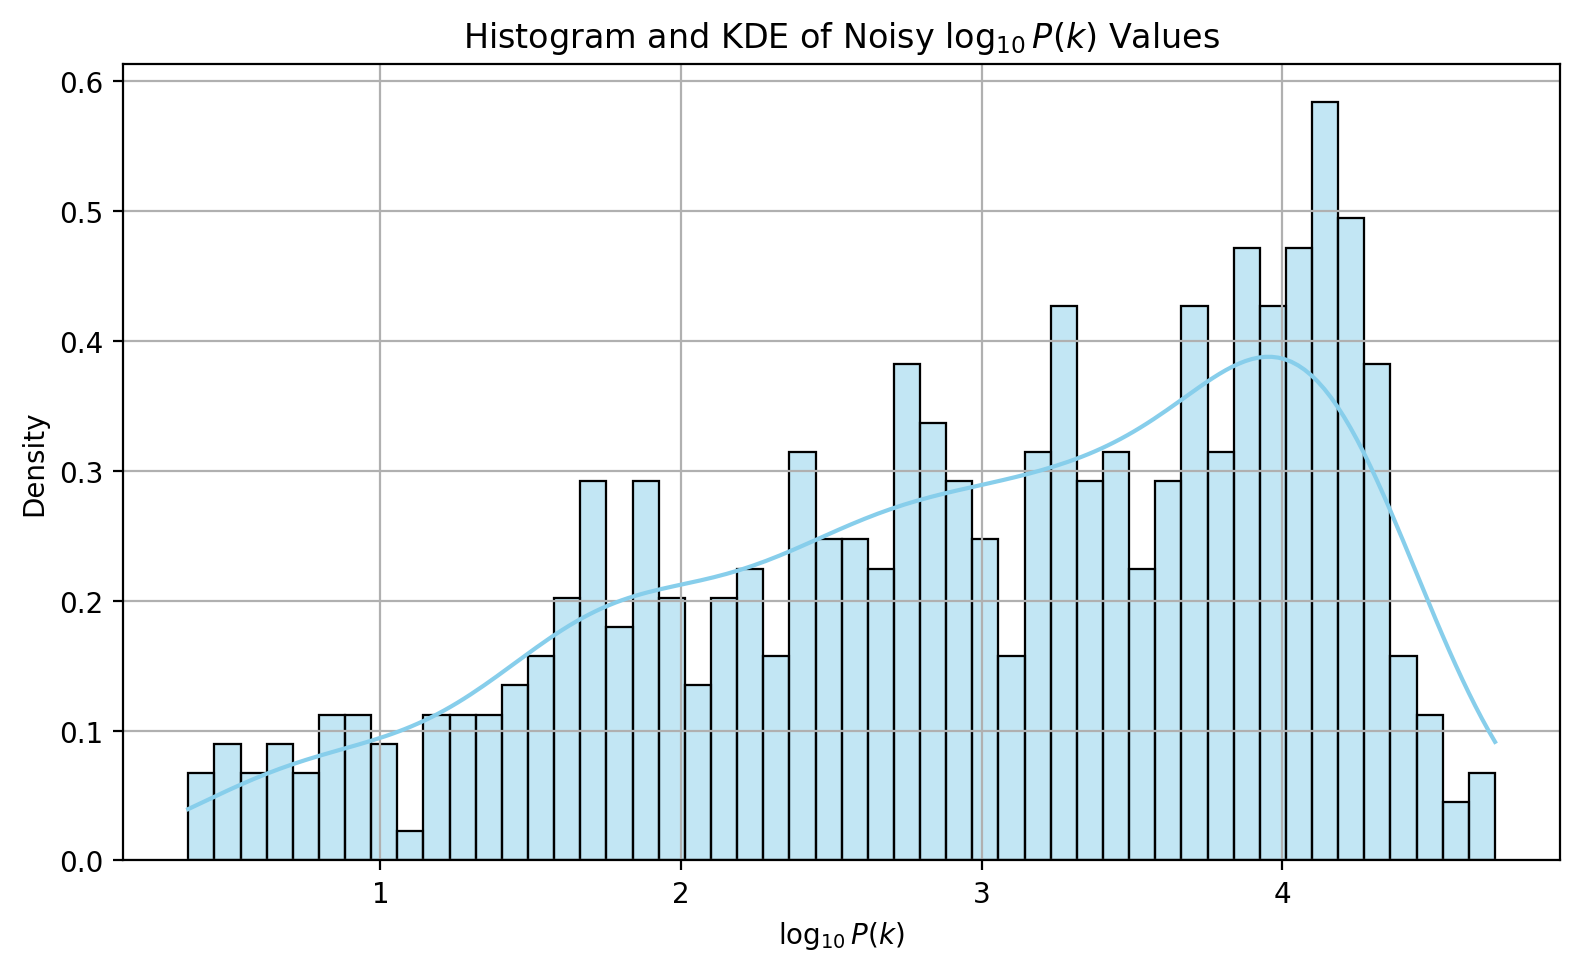

In [339]:
# Plot histogram and KDE for log10(P(k))
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_test['log_P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


# Bayes Flow Workflow

## Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [340]:
simulator = bf.make_simulator([prior, likelihood])

In [341]:
# simulator.sample(2)

###  Adapter 

In [415]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
)

In [416]:
adapter_std = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
    .standardize("summary_variables")
)

### Summary Network

In [461]:
summary_network_Deep = bf.networks.DeepSet()

In [462]:
summary_network_MLP = bf.networks.MLP()

In [476]:
summary_network_Set_Trans = bf.networks.SetTransformer()

# 1) Affine Coupling Model

### Affine Inference Network

In [417]:
inference_network_affine = bf.networks.CouplingFlow() 

### Affine Workflow

1) Deep

In [472]:
workflow_affine_Deep = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_Deep,
     adapter=adapter_std,
     simulator=simulator,
    standardize=["inference_variables", "summary_variables"]
)

 2) MLP (Failed)

In [468]:
workflow_affine_MLP = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_MLP,
     adapter=adapter_std,
     simulator=simulator
)

3) Set Transformer

In [477]:
workflow_affine_Set_Trans = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network_Set_Trans,
     adapter=adapter_std,
     simulator=simulator
)

### Simulating Datasets for 
1) Training
2) Validation
3) Test

# Timing training data sampling
start_time = time.time()
training_data = workflow_affine.simulate(10000)
training_duration = time.time() - start_time
print(f"Training data simulation took {training_duration:.2f} seconds.")

# Timing validation data sampling
start_time = time.time()
validation_data = workflow_affine.simulate(1000)
validation_duration = time.time() - start_time
print(f"Validation data simulation took {validation_duration:.2f} seconds.")

# Timing test data sampling
start_time = time.time()
test_data = workflow_affine.simulate(1000)
test_duration = time.time() - start_time
print(f"Test data simulation took {test_duration:.2f} seconds.")

## Just testing 

Plotting any random simulated dataset just to know whether the simulator working properly

In [350]:
# training_data['log_P_k_noisy'].shape

(10000, 256, 1)

In [408]:
# training_data['log_P_k_noisy'][random_idx].squeeze().shape

# Select a random sample
random_idx = np.random.randint(0, 100)

# Extract and unroll to 1D array
log_pk_sample = training_data['log_P_k_noisy'][random_idx].squeeze()

# KDE estimation
kde = gaussian_kde(log_pk_sample)
x_vals = np.linspace(log_pk_sample.min(), log_pk_sample.max(), 1000)
density = kde(x_vals)

# Plot KDE and Histogram
plt.figure(figsize=(8, 5))
plt.hist(log_pk_sample, bins=30, density=True, alpha=0.4, color='gray', label='Histogram')
plt.plot(x_vals, density, label='KDE', linewidth=2)

# Labels and titles
plt.xlabel('log(P(k))')
plt.ylabel('Density')
plt.title(f'KDE and Histogram of log P(k), sample #{random_idx}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This means that the simulator is correct

# Training affine with different summary networks

In [470]:
training_data['log_P_k_noisy'].shape

(10000, 256, 1)

In [1]:
training_data.keys()

NameError: name 'training_data' is not defined

(10000, 256, 1)

In [420]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

In [473]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_affine_Deep = workflow_affine_Deep.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

In [478]:
history_affine_Set_Trans = workflow_affine_Set_Trans.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
12/79 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - loss: 4.1439

KeyboardInterrupt: 

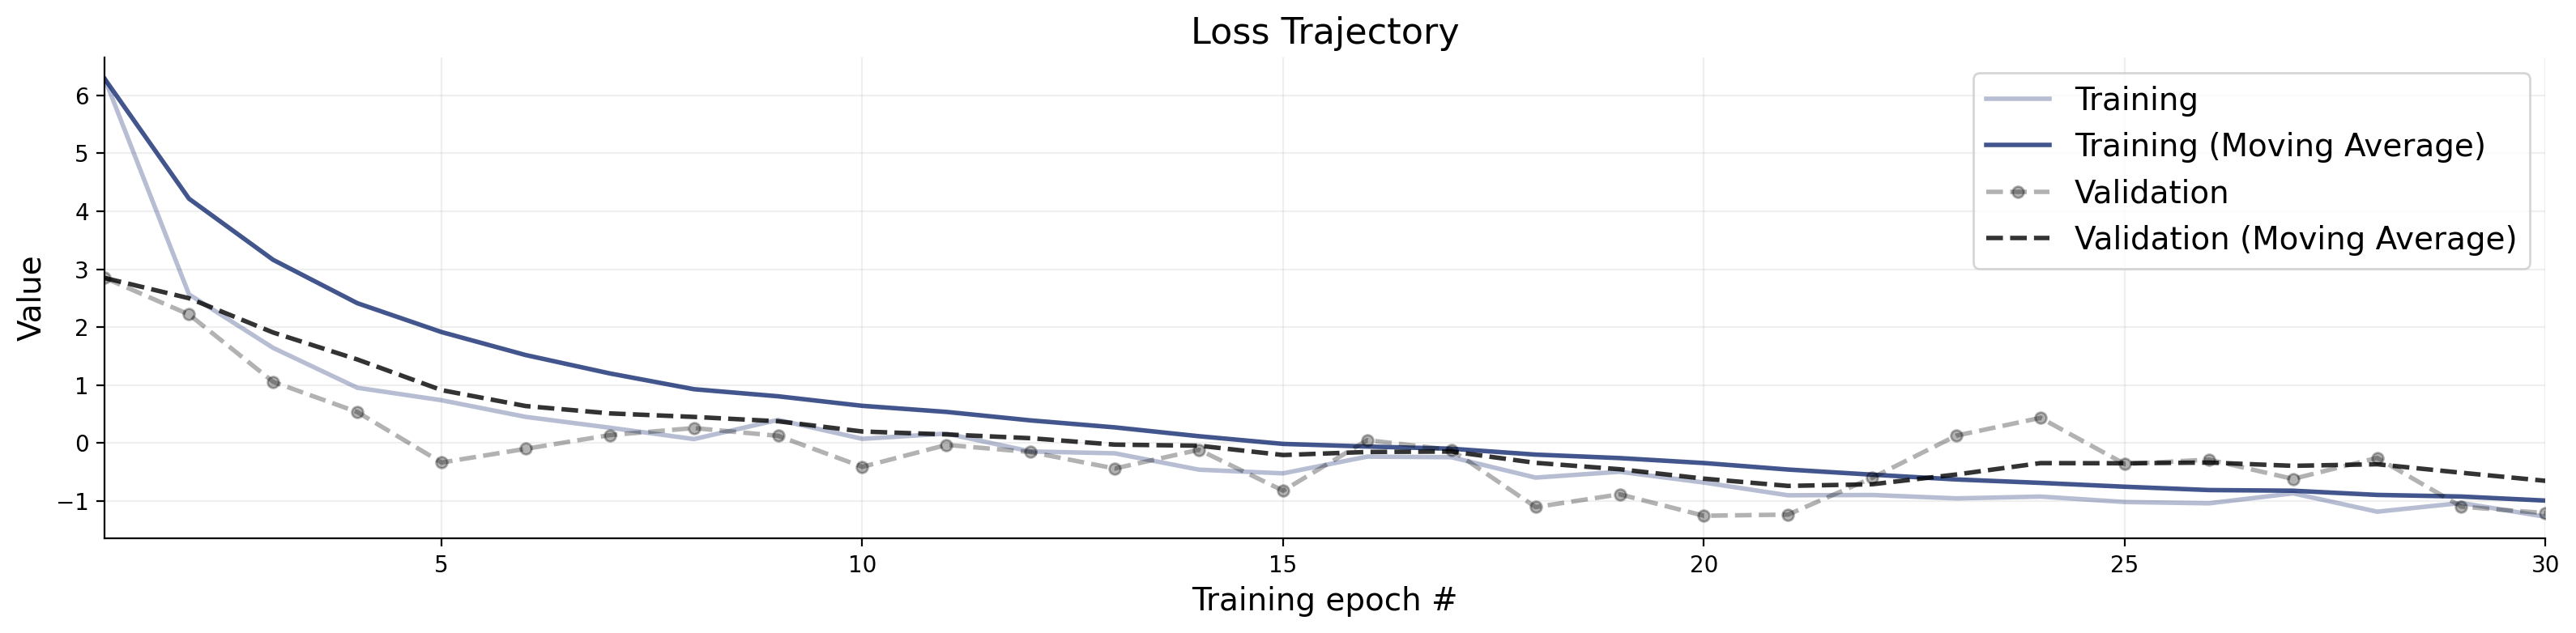

In [488]:
loss_affine_Deep = bf.diagnostics.plots.loss(history_affine_Deep)

In [ ]:
#loss_affine_Set_Trans = bf.diagnostics.plots.loss(history_affine_Set_Trans)

In [491]:
post_draws_affine_Deep = workflow_affine_Deep.sample(conditions=test_data, num_samples=100)

In [ ]:
post_draws_affine_Deep_train = workflow_affine_Deep.sample(conditions=training_data, num_samples=1000)

In [492]:
#post_draws_affine_Set_Trans = workflow_affine_Set_Trans.sample(conditions=test_data, num_samples=1000)

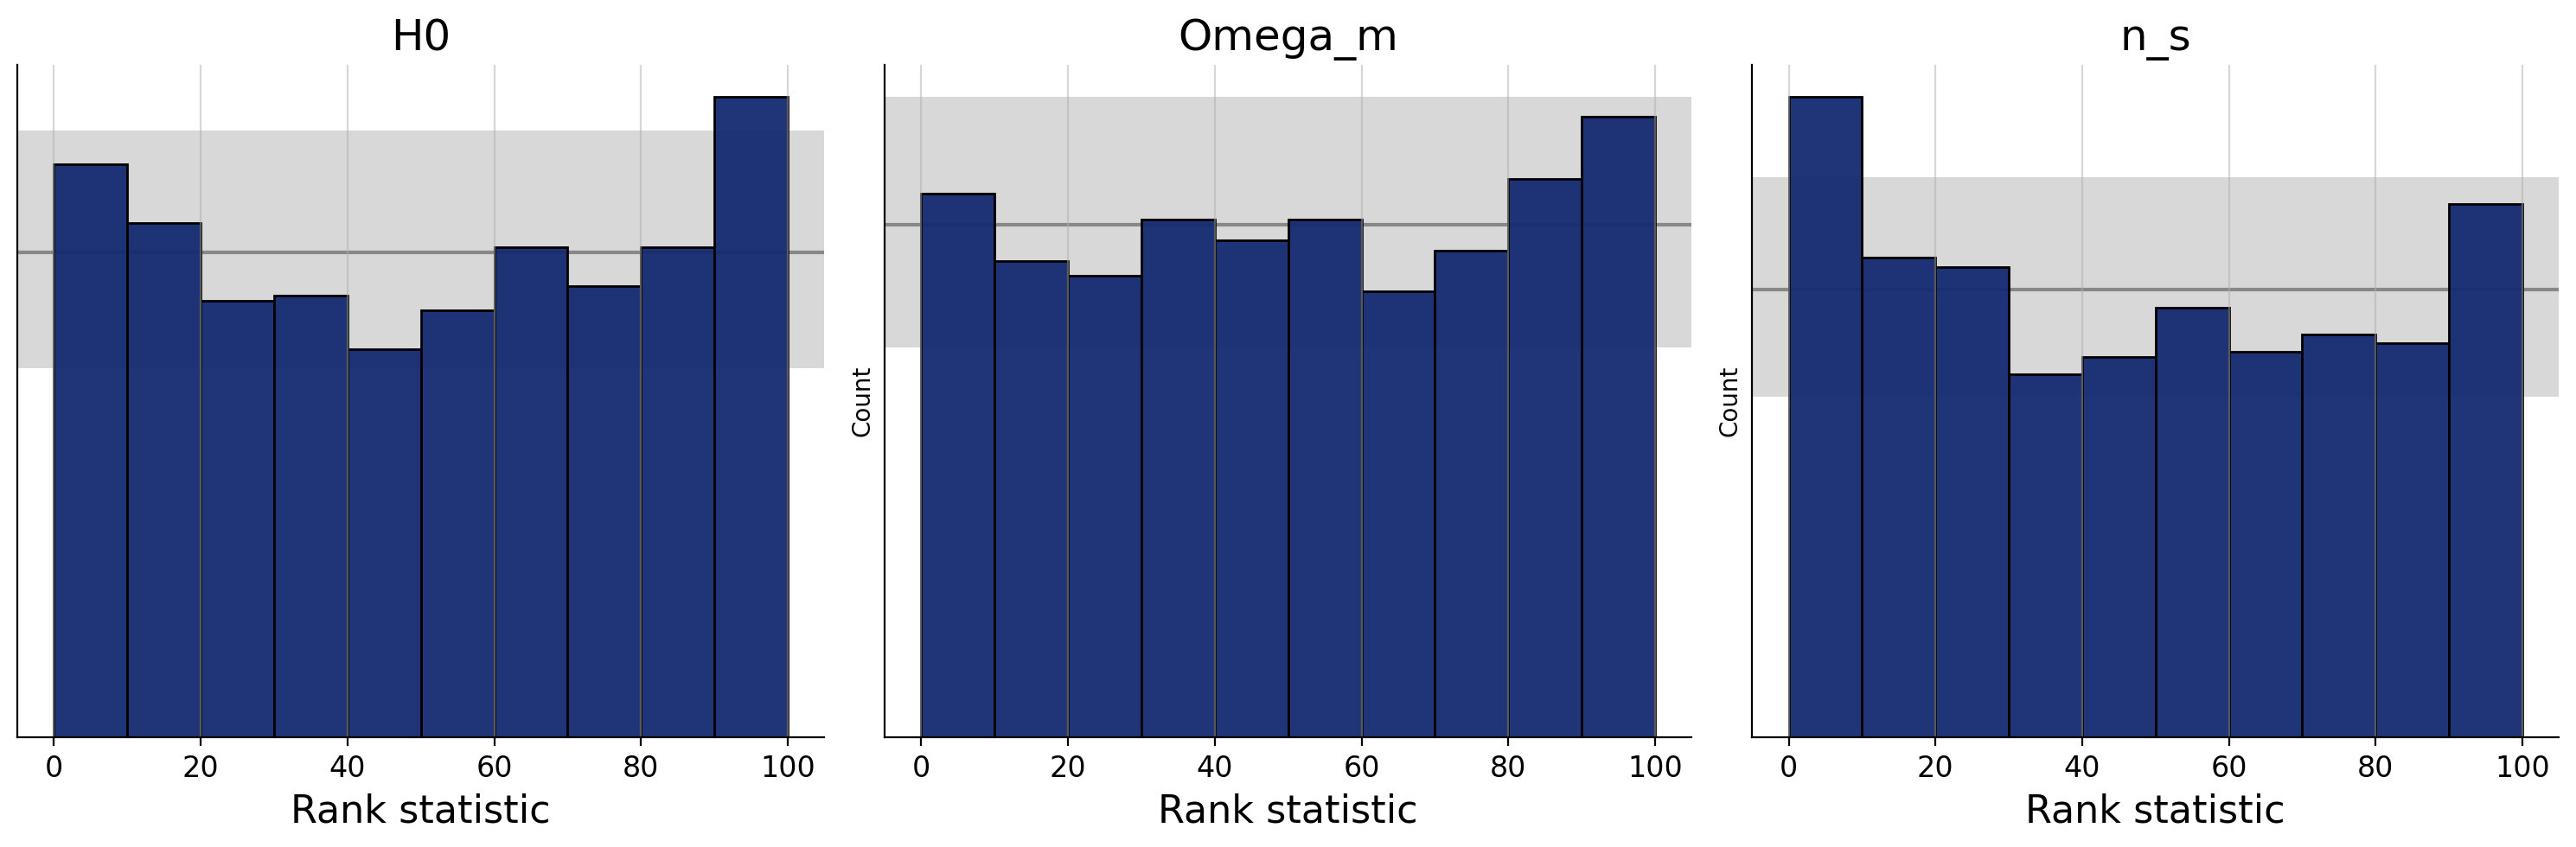

In [493]:
rank_calibration_hist_affine_Deep = bf.diagnostics.plots.calibration_histogram(
    estimates=post_draws_affine_Deep, 
    targets=test_data
)

In [ ]:
recovery_Deep = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=test_data,
    variable_names=par_names
)

# Test Data

### Sample posterior from the trained affine inference network
Sample 1000 posterior samples from each simulated dataset of 300

In [427]:
test_data['log_P_k_noisy'].shape

(300, 256, 1)

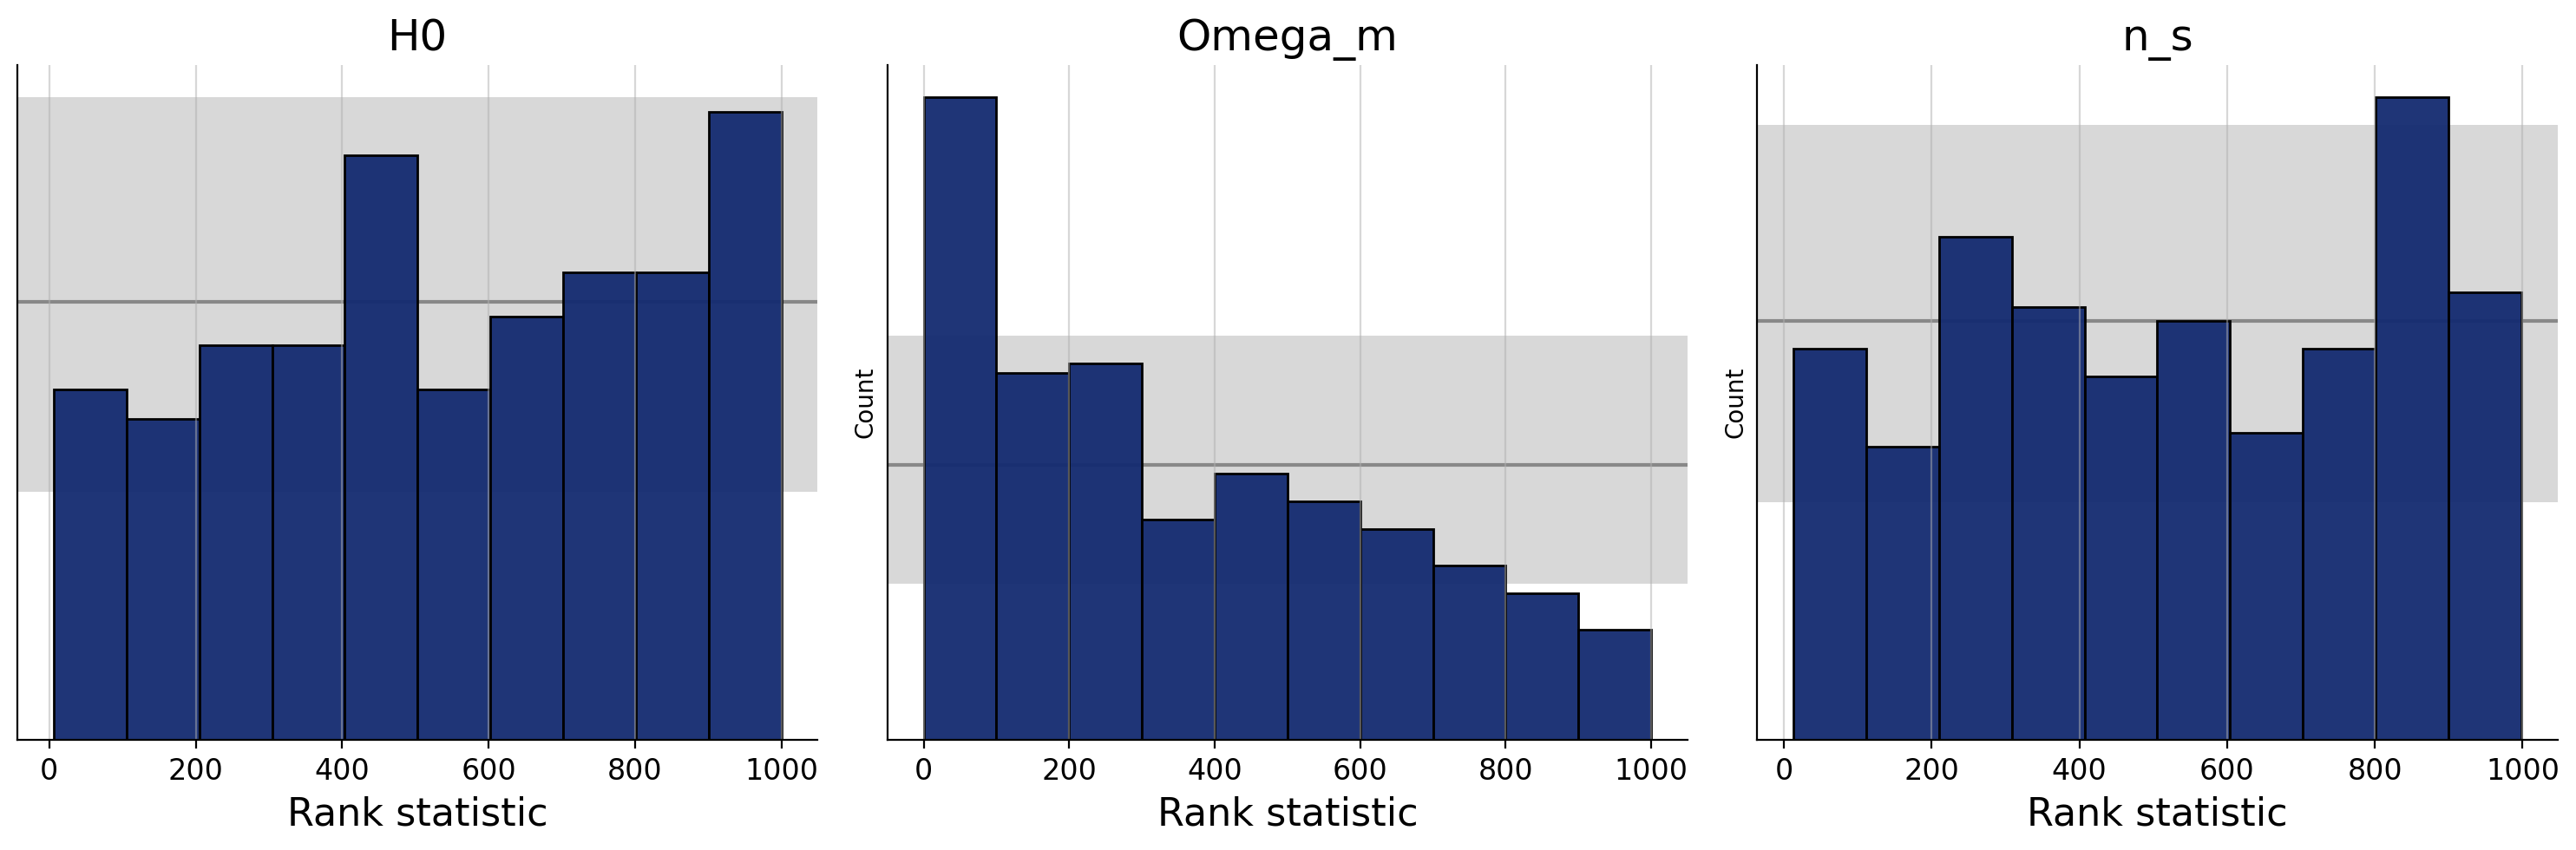

In [428]:
rank_affine = f = bf.diagnostics.plots.calibration_histogram(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

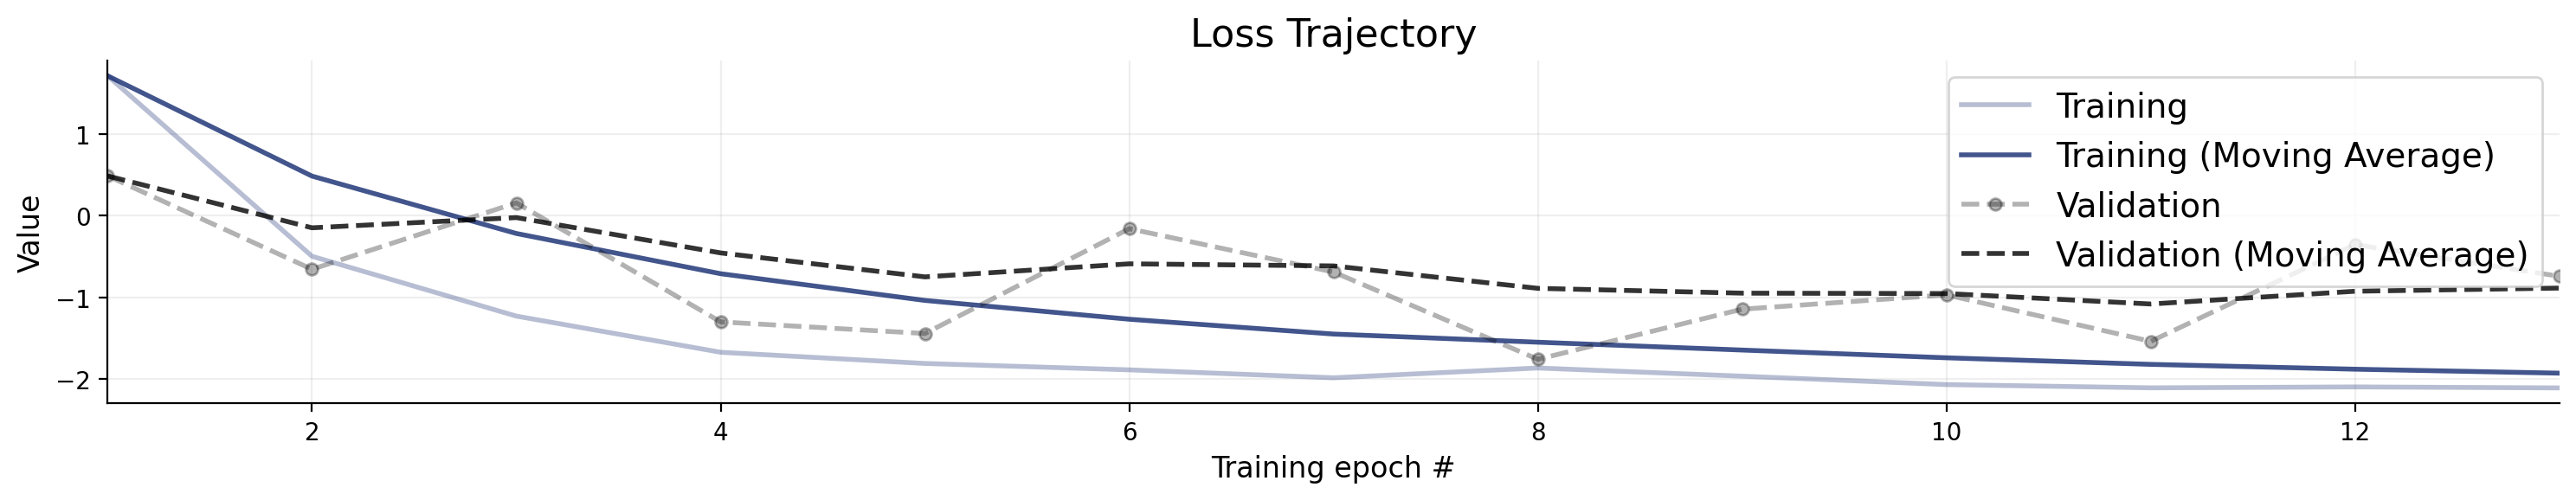

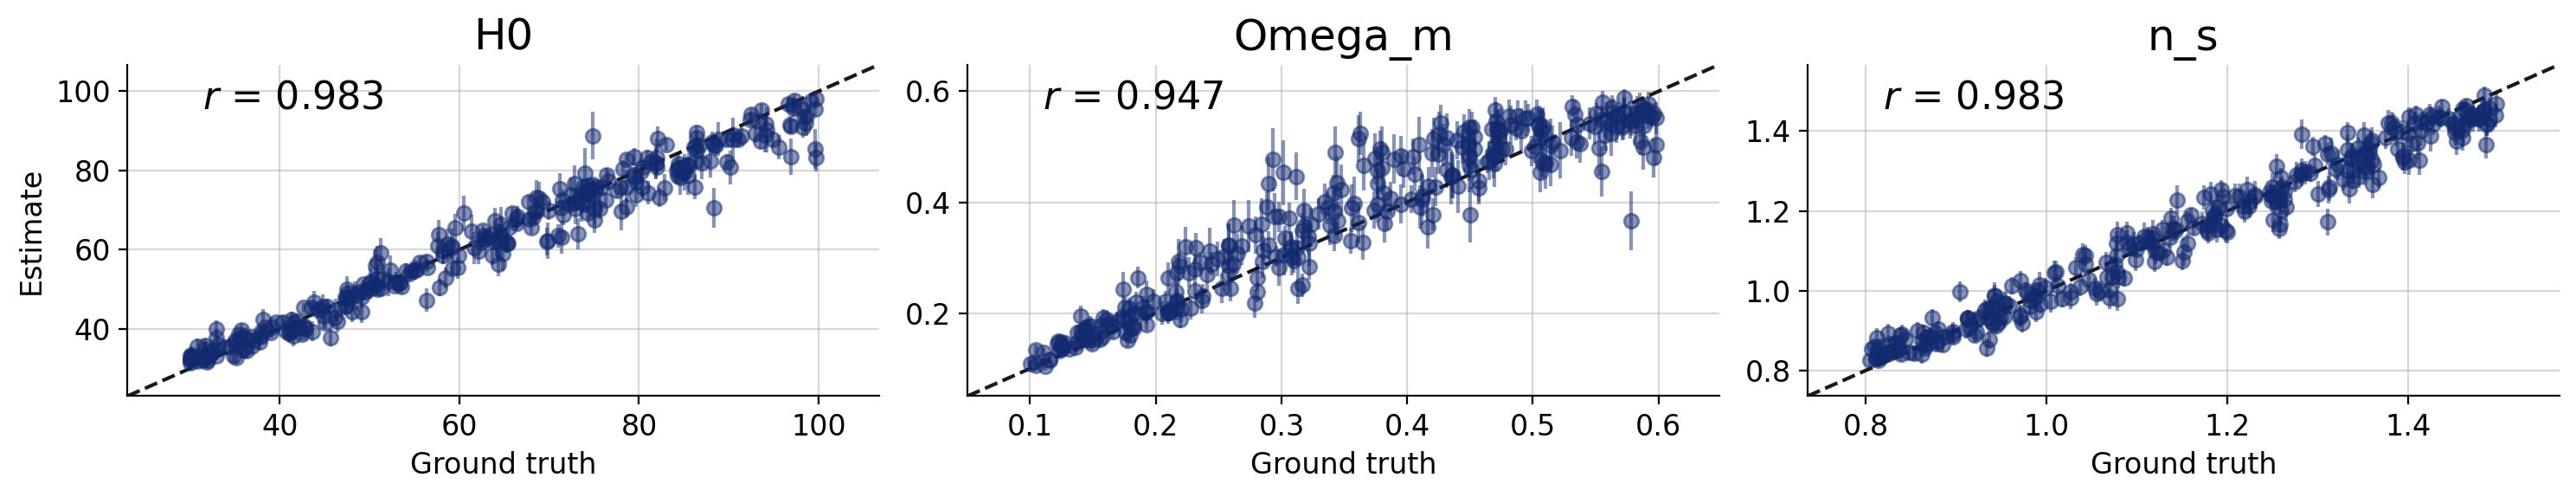

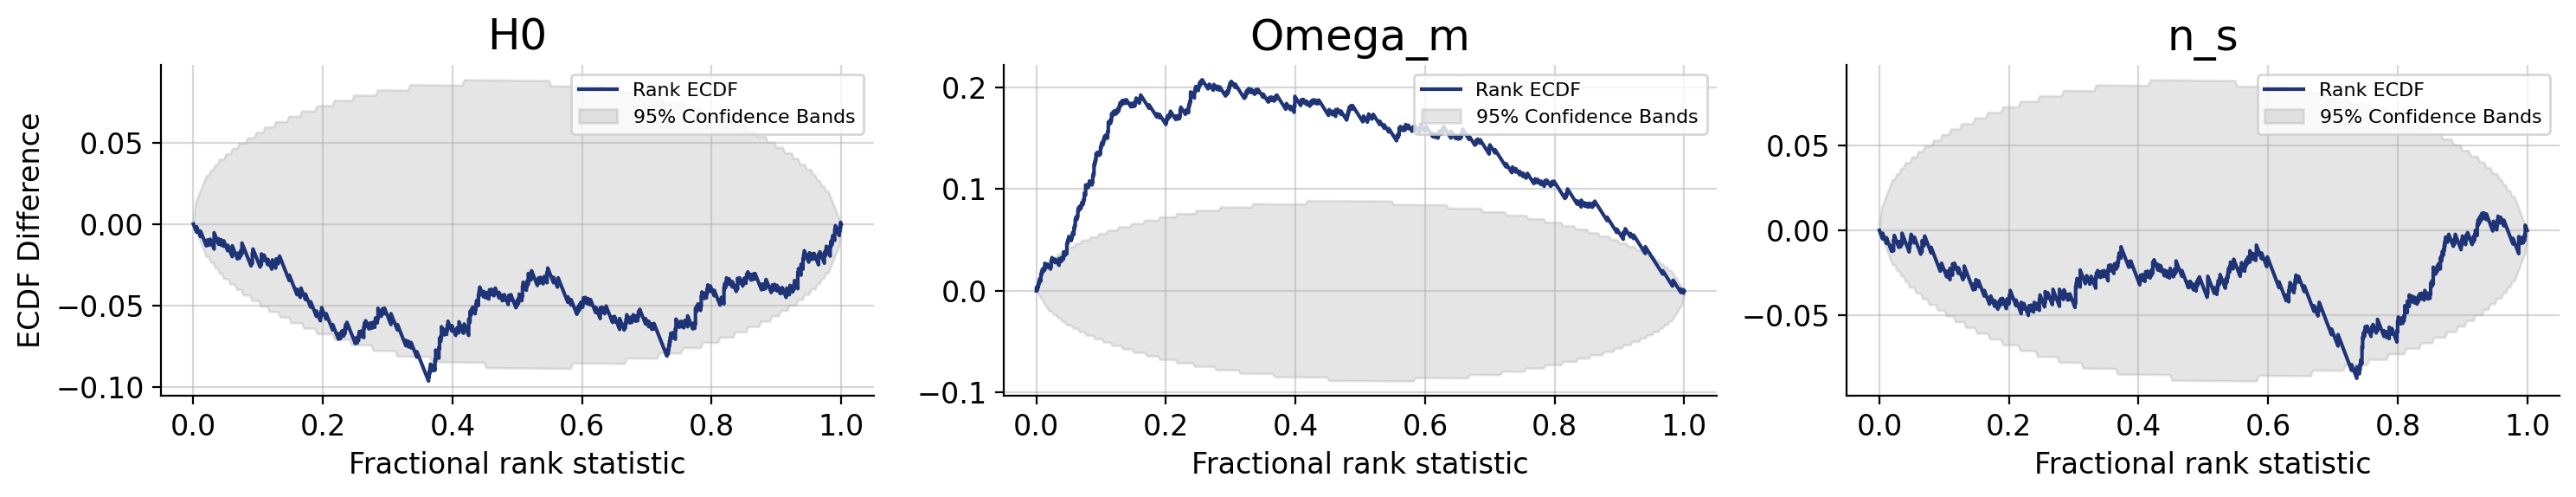

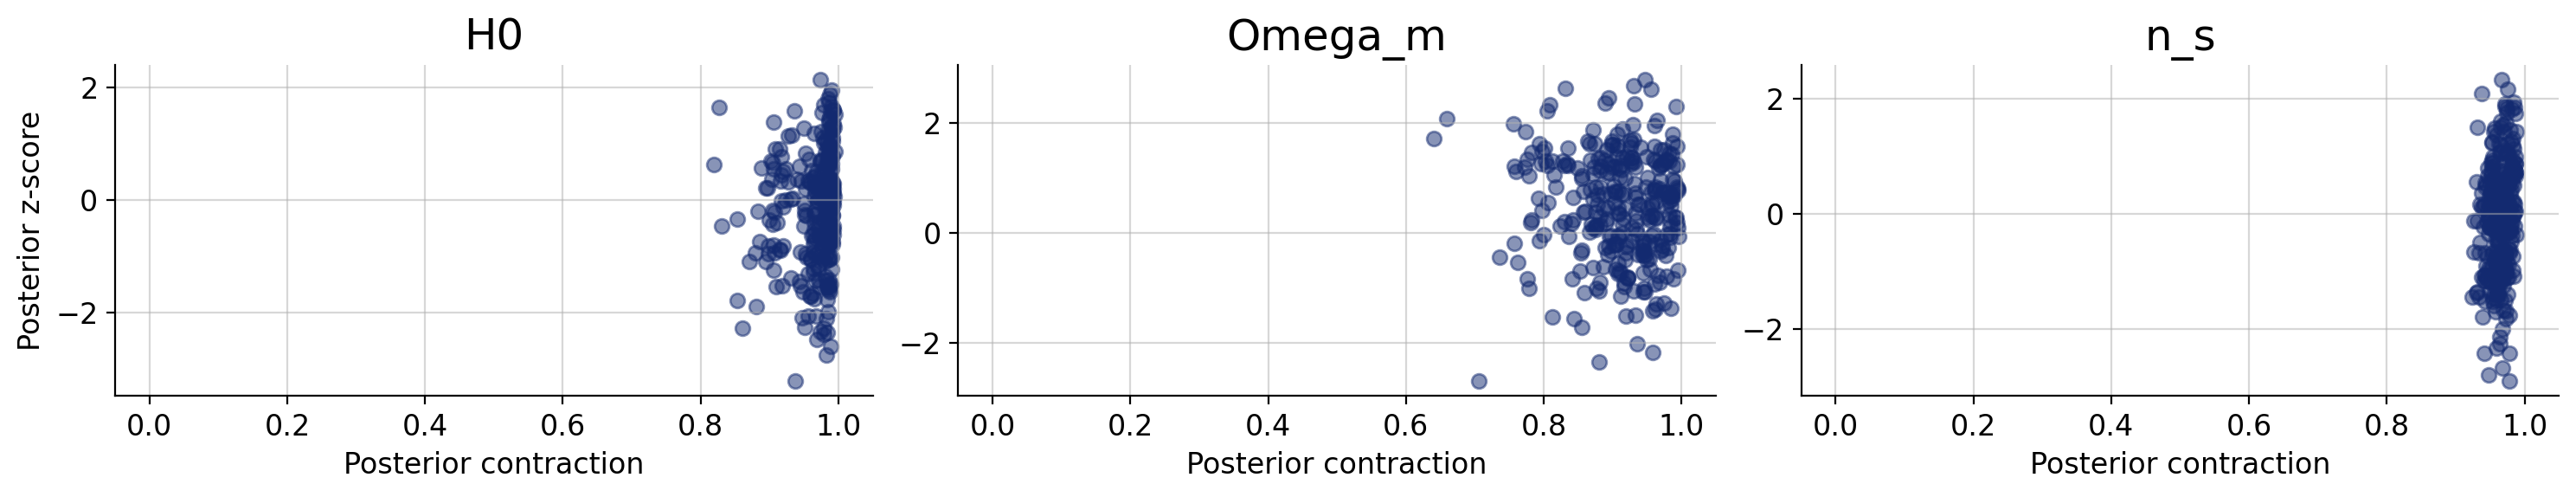

In [429]:
figures_affine = workflow_affine.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 2) Inference with Spline coupling

In [431]:
inference_network_spline = bf.networks.CouplingFlow(transform="spline")

In [432]:
workflow_spline = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network,
     adapter=adapter_std,
     simulator=simulator
)

In [433]:
history_spline = workflow_spline.fit_offline(
    data = training_data,
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 196s 719ms/step - loss: 0.9350 - val_loss: 1.1110
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 515ms/step - loss: -0.2450 - val_loss: -0.7520
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 502ms/step - loss: -0.6005 - val_loss: -0.1877
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - loss: -0.6901 - val_loss: 0.2789
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 509ms/step - loss: -0.9039 - val_loss: -1.2017
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 509ms/step - loss: -1.3616 - val_loss: 0.1933
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 545ms/step - loss: -1.3229 - val_loss: -0.0071
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 514ms/step - loss: -1.4306 - val_loss: -1.3316
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 513ms/step - loss: -1.4067 - val_loss: -0.5528
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - loss: -1.3268 - val_loss: -0.8696
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 526ms/step - loss: -1.5540 - val_loss: -1.0017
Epoch 12/50
79/79 ━━━━

In [434]:
post_samples_spline = workflow_spline.sample(conditions=test_data, num_samples=1000)

In [435]:
# samples_spline["H0"][1]

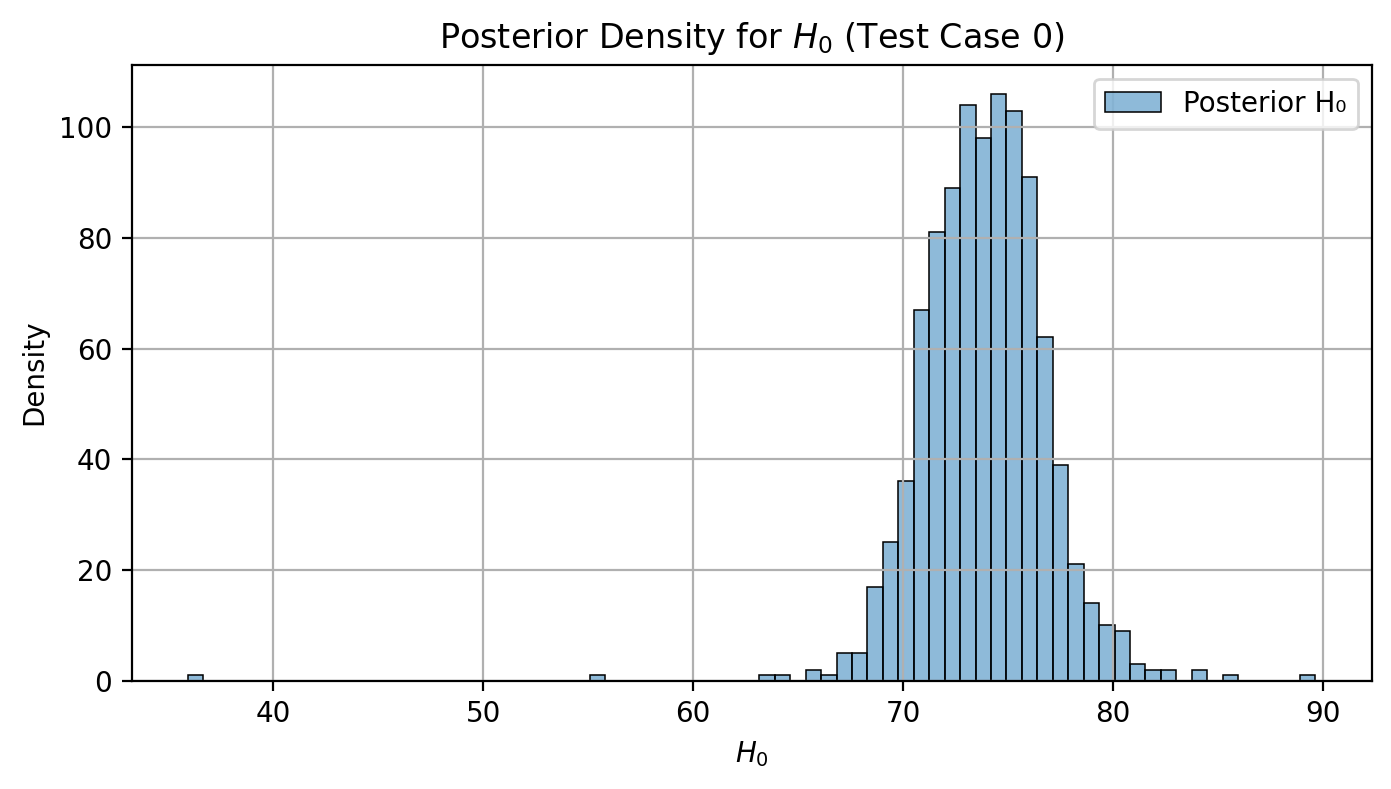

In [436]:
plt.figure(figsize=(8, 4))
sns.histplot(post_samples_spline["H0"][-1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["Omega_m"][1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["n_s"][1], fill=True, color="skyblue", label="Posterior H₀")
plt.title("Posterior Density for $H_0$ (Test Case 0)")
plt.xlabel("$H_0$")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


In [369]:
#str(test_data)

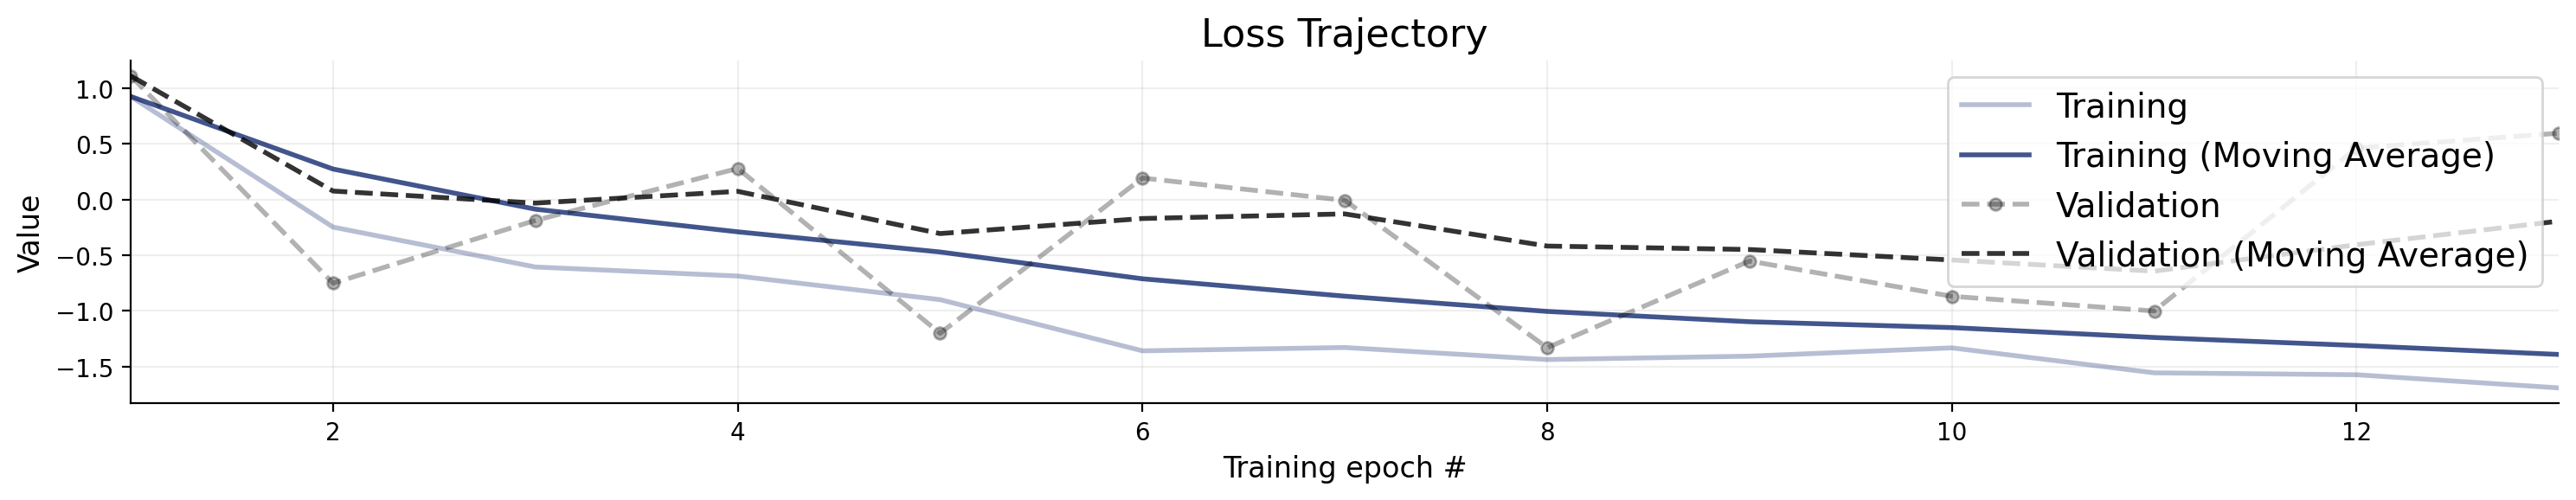

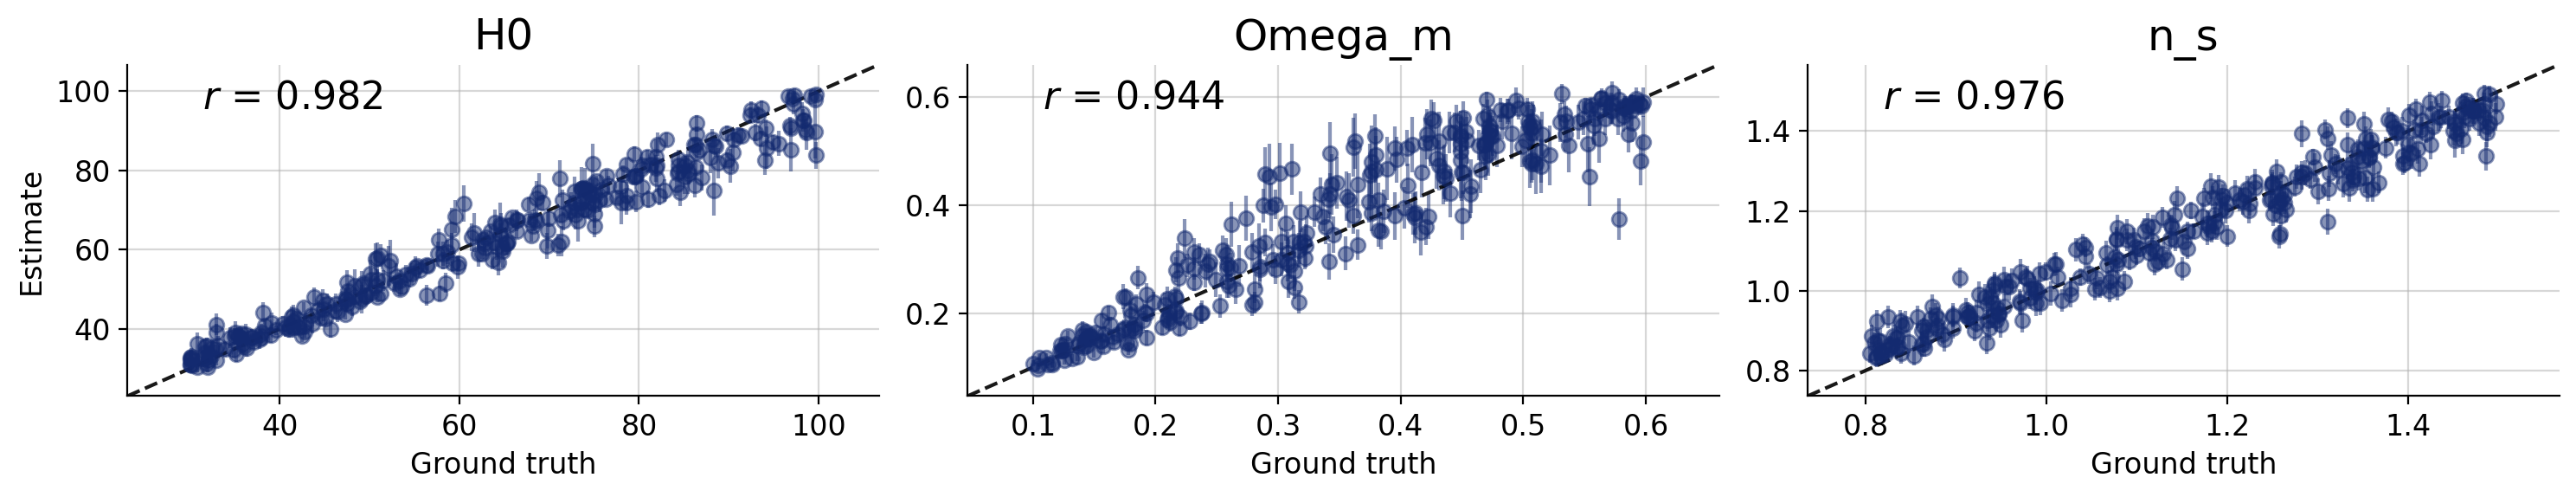

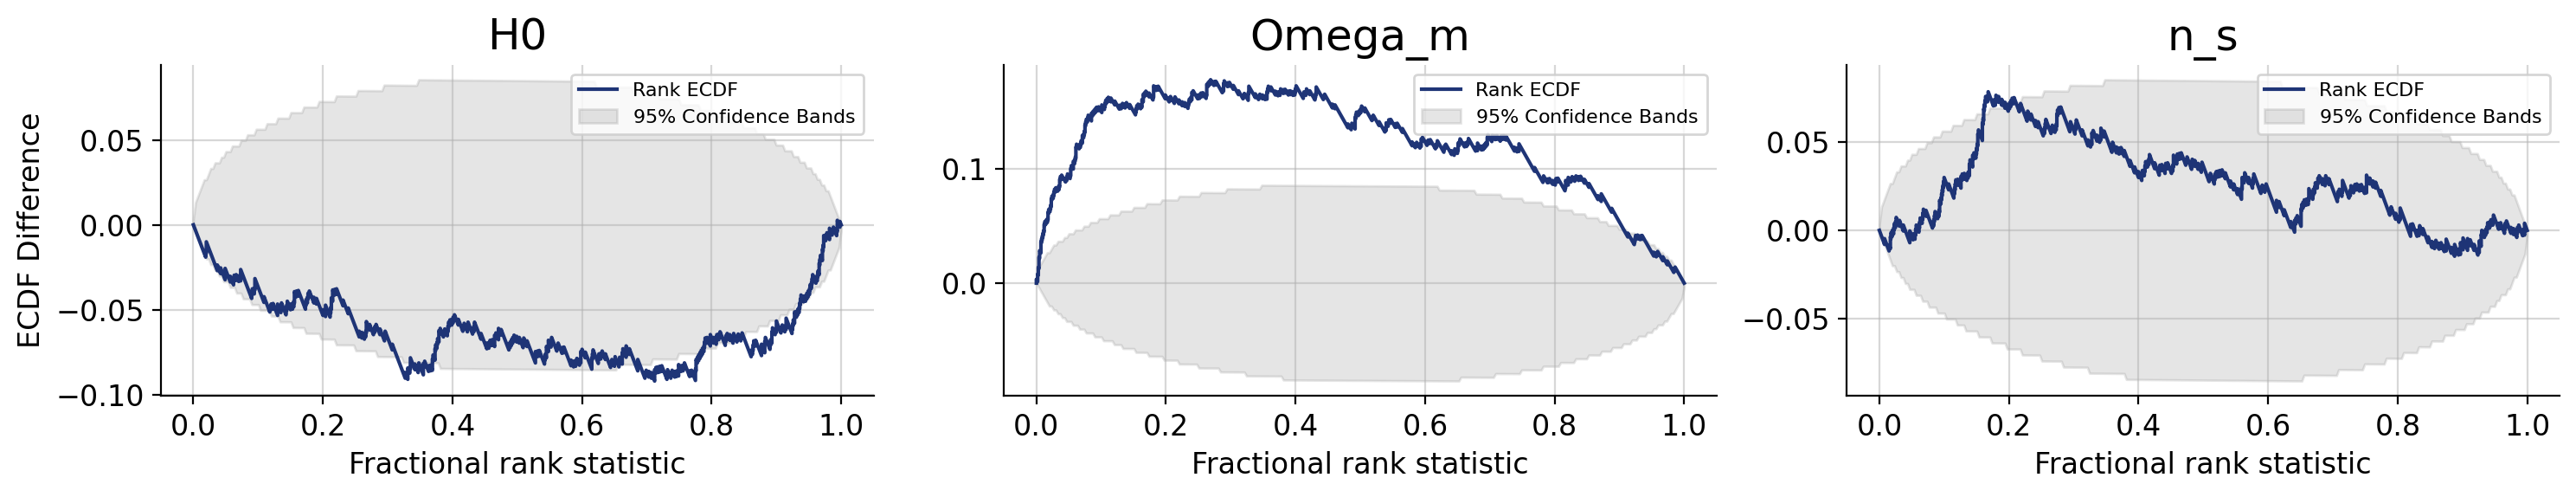

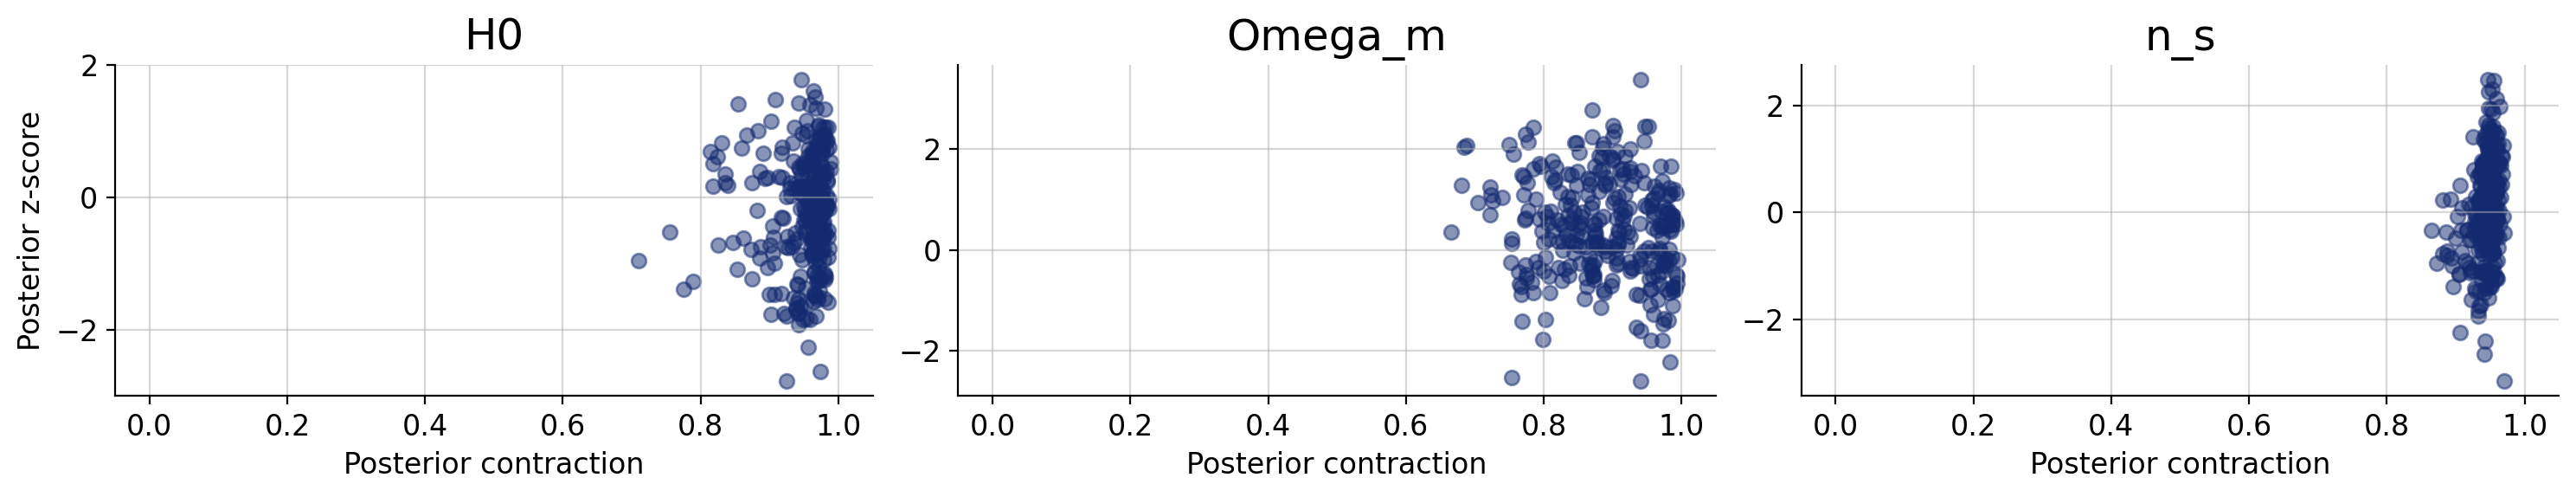

In [437]:
figures_spline = workflow_spline.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 3) Flow matching 

In [438]:
inference_network_flow = bf.networks.FlowMatching()

In [439]:
workflow_flow = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network,
     adapter=adapter_std,
     simulator=simulator
)

In [440]:
history_flow = workflow_flow.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 520ms/step - loss: 23.0427 - val_loss: 0.8083
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 487ms/step - loss: 0.9717 - val_loss: 0.5149
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - loss: 0.7444 - val_loss: 0.5270
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 499ms/step - loss: 0.6255 - val_loss: 0.5960
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 489ms/step - loss: 0.6061 - val_loss: 0.5145
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 501ms/step - loss: 0.5740 - val_loss: 0.4510
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - loss: 0.5189 - val_loss: 0.5993
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - loss: 0.5034 - val_loss: 0.5095
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - loss: 0.4917 - val_loss: 0.3978
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - loss: 0.4877 - val_loss: 0.4468
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - loss: 0.4769 - val_loss: 0.4900
Epoch 12/100
79/79 ━━━━━━━━━━

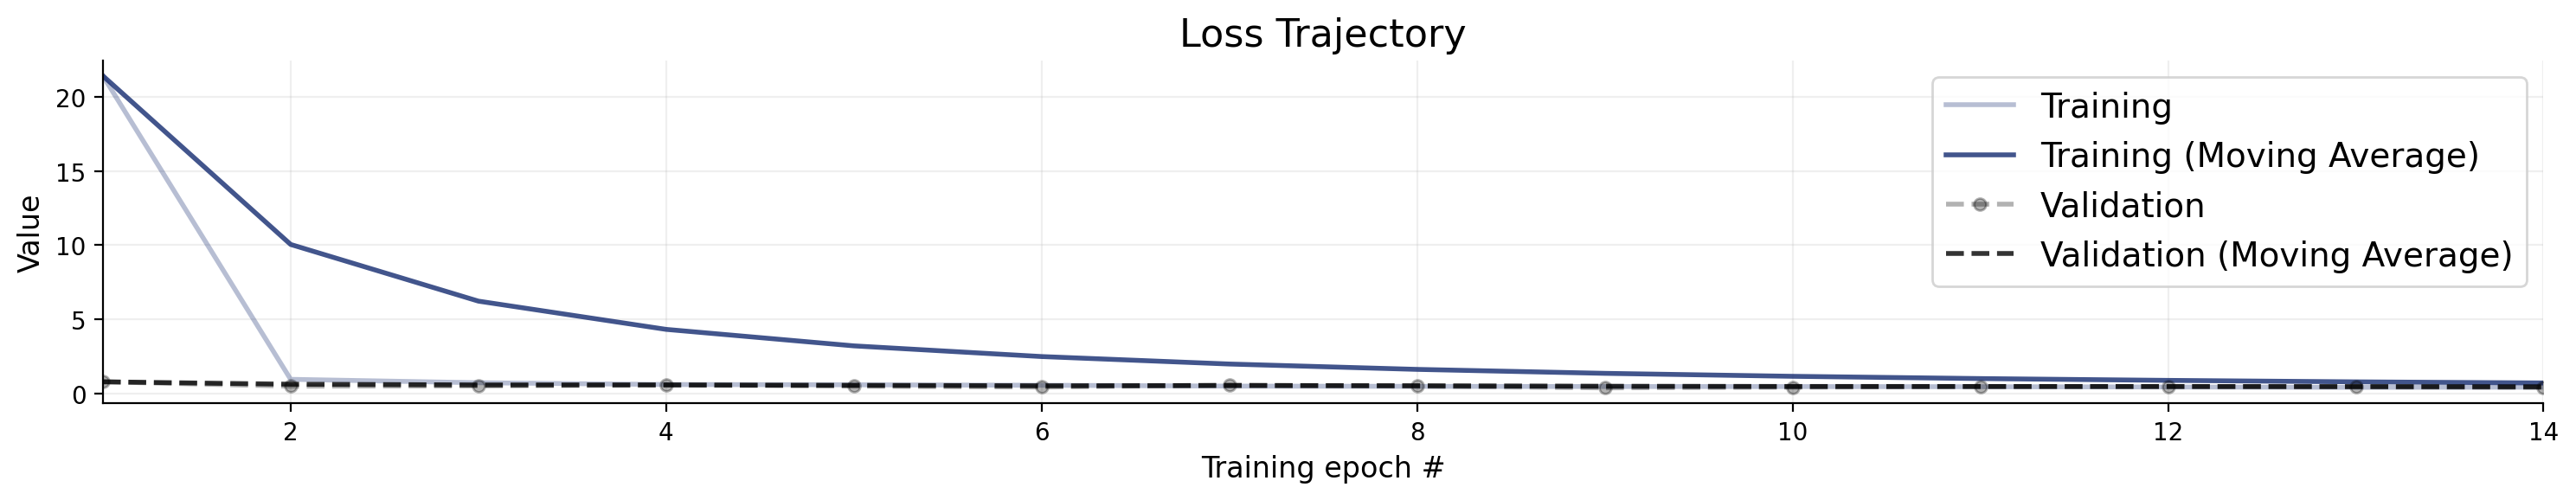

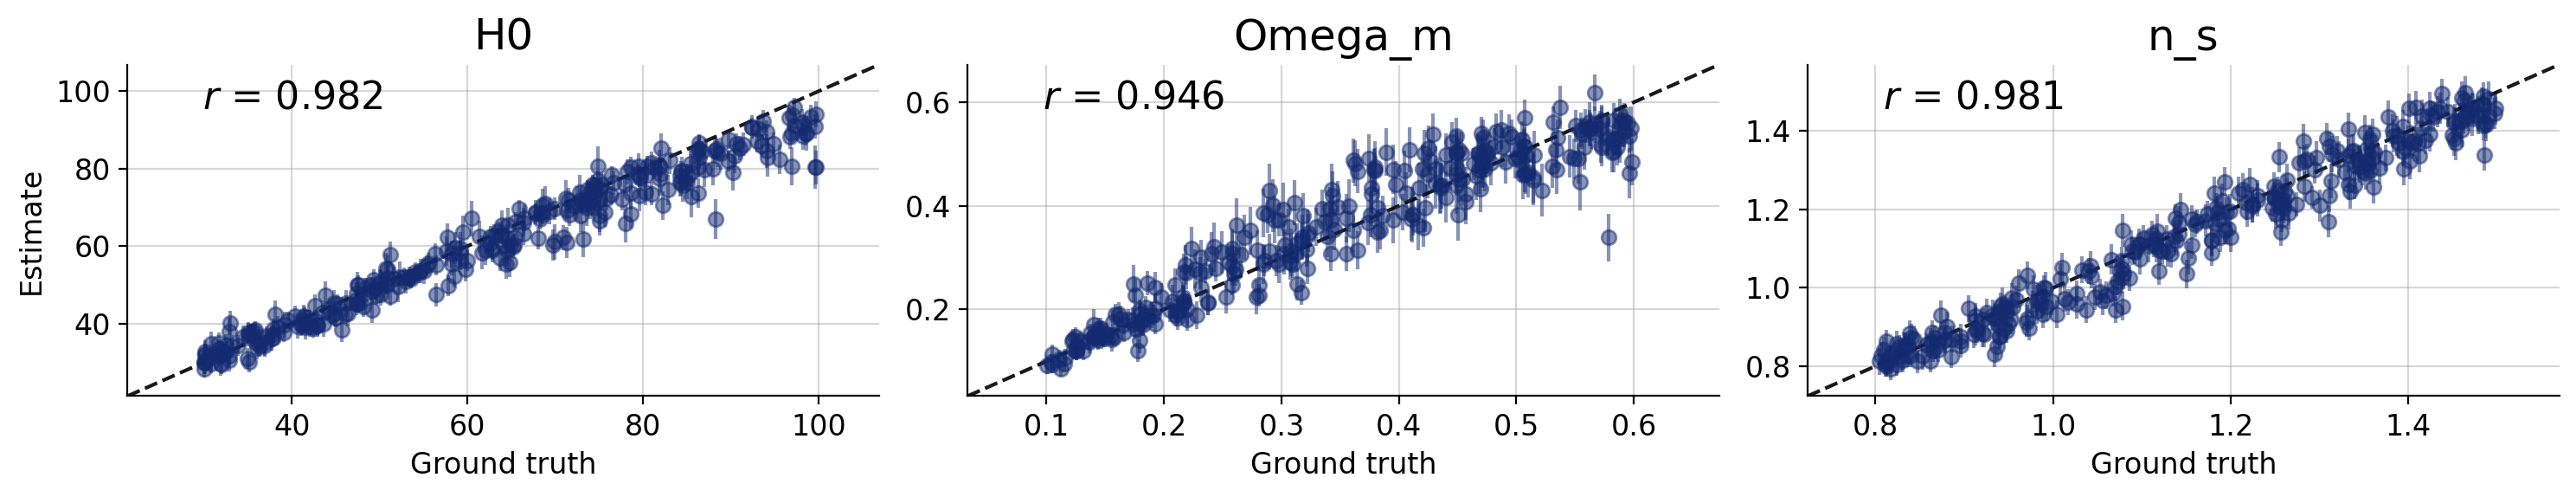

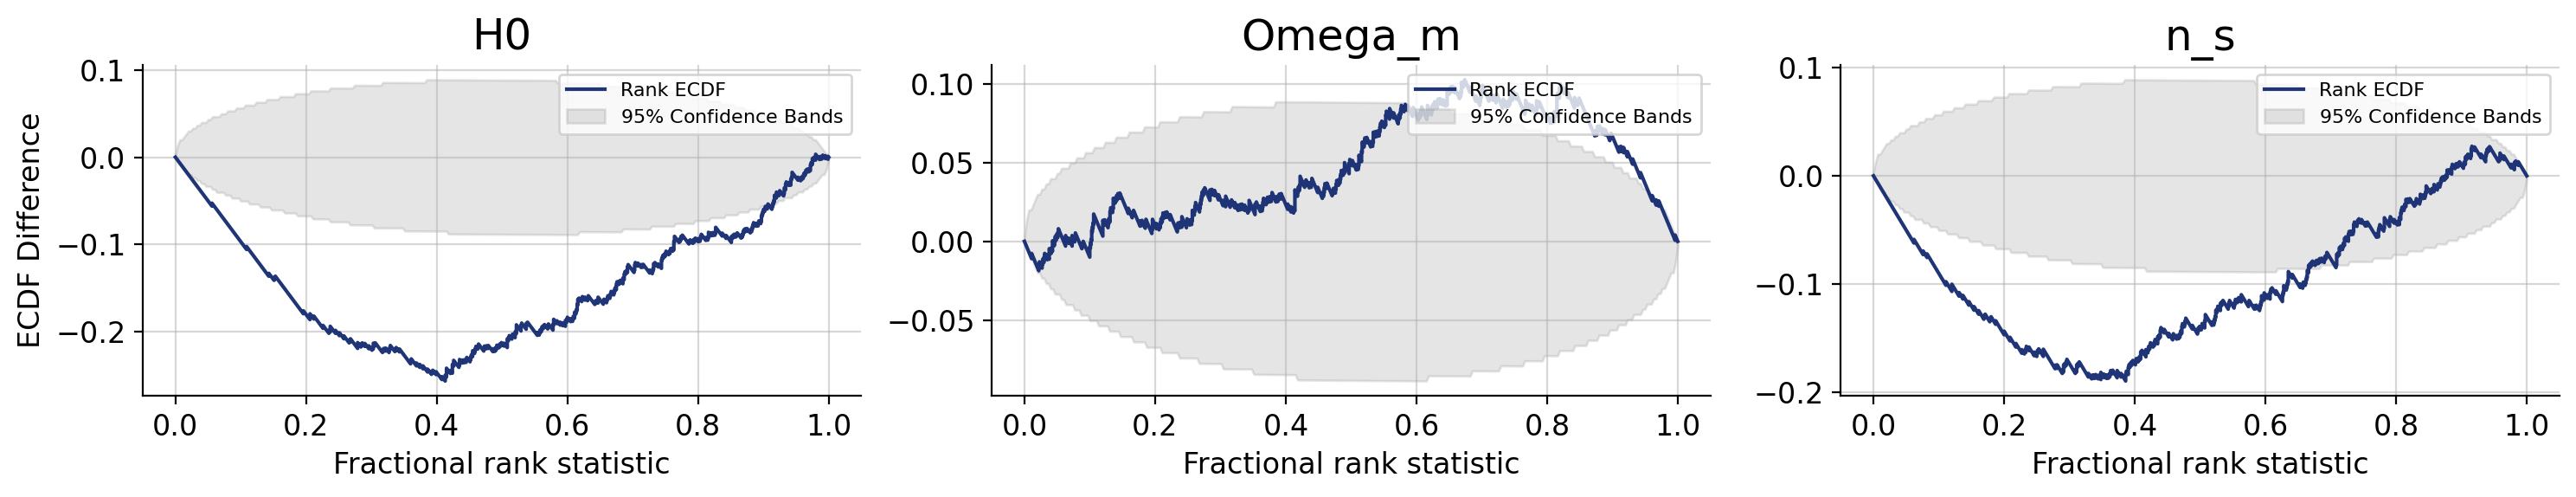

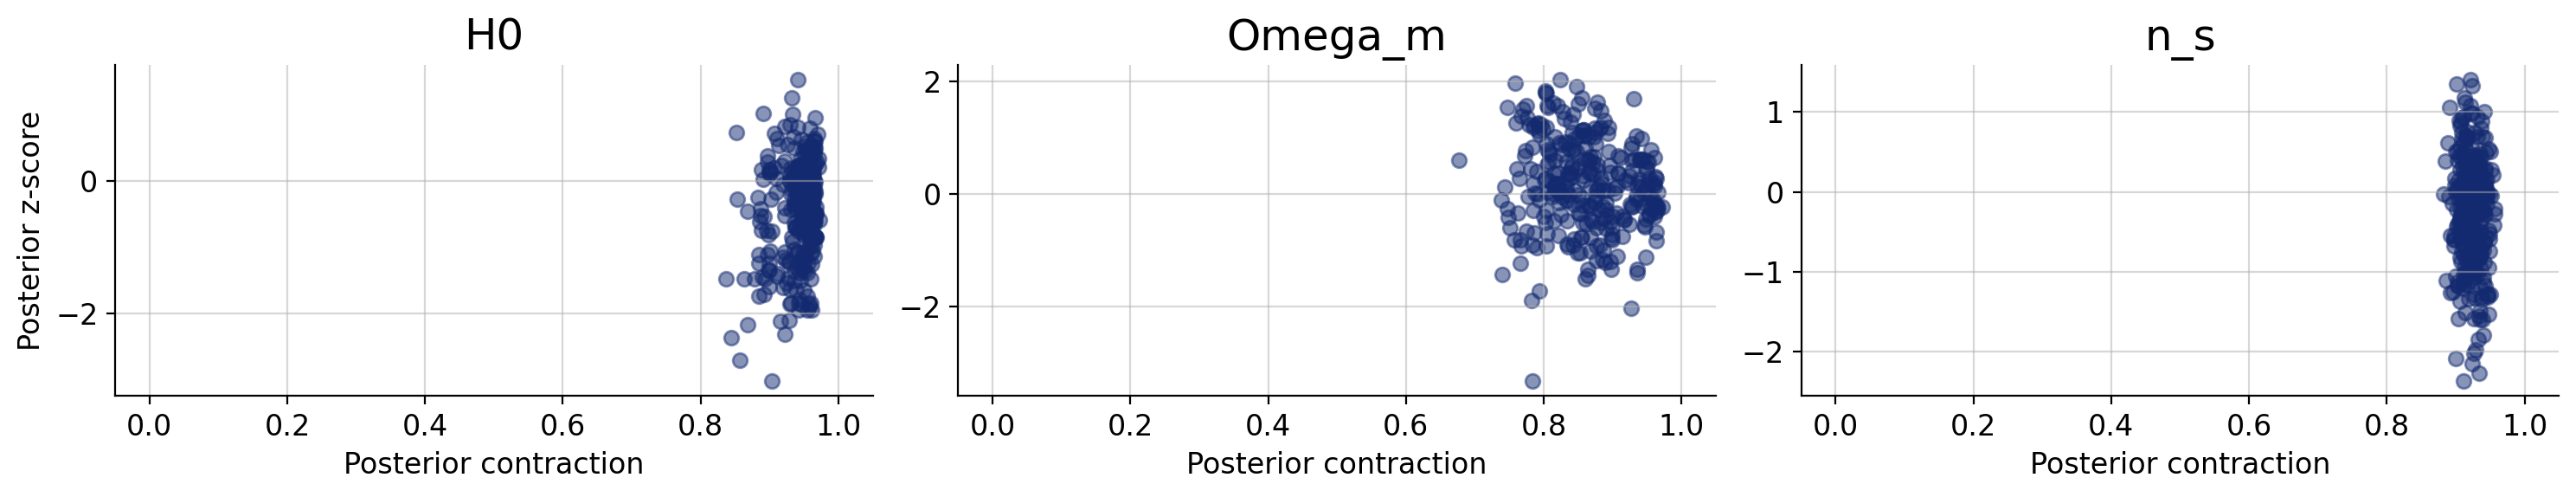

In [442]:
figures_spline = workflow_flow.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)